#### Run Options: Set these options before running

In [1]:
fn_h5 = 'tf_mnist_model_09.h5'
fn_tflite = 'tf_mnist_model_09.tflite'
class_labels = "0123456789"

save_as_tflite = False
train = False
n_epochs = 10

#### 0. Import Modules

In [2]:
from ImageUtilities import *
from MNISTUtilities import *
import numpy as np
import cv2
import matplotlib.pyplot as plt
import pprint

import tensorflow as tf
from tensorflow import keras

#### 1. Read MNIST

Reading: test-images-idx3-ubyte.gz  ...
2051 10000 28 28
(10000, 28, 28)
Reading: test-labels-idx1-ubyte.gz  ...
2049 10000 0 0
(10000,)
Reading: train-images-idx3-ubyte.gz  ...
2051 60000 28 28
(60000, 28, 28)
Reading: train-labels-idx1-ubyte.gz  ...
2049 60000 0 0
(60000,)
(60000, 784)
[0 1 2 3 4 5 6 7 8 9]
10
Train Set:


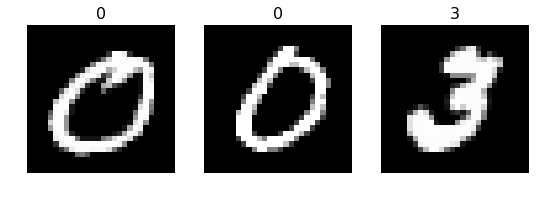

Test Set:


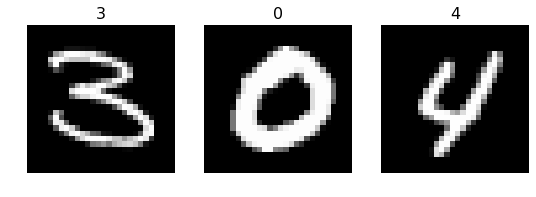

In [3]:
X_train, X_test, y_train, y_test = read_and_transform_MNIST_data(dir_path='../../../data/mnist_digit/', category='digit-data', transpose=False)
#y_train, y_test = (y_train - 1), (y_test - 1)

print(np.unique(y_train))
print(len(class_labels))

#Sanity Check
sanity_check(X_train, X_test, y_train, y_test, class_labels)

#### 2. Model Training

##### 2.1 Build and Compile Model

In [4]:
if(train == True):
    rows = X_train.shape[0]
    dims = X_train.shape[1]
    classes = np.unique(y_test).shape[0]
    print(rows, dims, classes)

    model = tf.keras.models.Sequential([
        keras.layers.Dense(200, activation=tf.keras.activations.relu, input_shape=(dims,)),
        keras.layers.Dense(100, activation=tf.keras.activations.relu),
        keras.layers.Dense(50, activation=tf.keras.activations.relu),
        keras.layers.Dense(classes, activation=tf.keras.activations.softmax)
    ])

    model.compile(optimizer=tf.keras.optimizers.Adam(),
                     loss=tf.keras.losses.sparse_categorical_crossentropy ,
                     metrics=['accuracy'])

    model.summary()

##### 2.2 Train Model

In [5]:
if(train == True):
    model.fit(X_train, y_train, epochs = 10)

##### 2.3 Evaluate Trained Model

In [6]:
if(train == True):
    loss, acc = model.evaluate(X_test, y_test)
    print("Evaluation: [loss: {}, acc: {}]".format(loss, acc))

#### 3. Save Trained Model (as .h5 file)  & Optionally covert to .tflite for deployment

In [7]:
if(train == True):
    #Save trained model
    model.save(fn_h5)

#Convert model to tflite format
if (save_as_tflite == True):
    converter = tf.lite.TFLiteConverter.from_keras_model_file(fn_h5)
    mnist_digits_model = converter.convert()
    open(fn_tflite, "wb").write(mnist_digits_model)

#### 4. User Image Processing and Prediction

###### i. Read Image

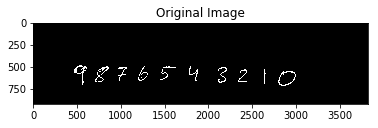

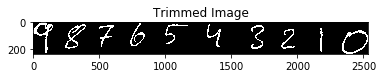

In [17]:
img = cv2.imread('../numbers.jpg')
img_bin = binarize_image(img)

plt.title("Original Image")
plt.imshow(img_bin, cmap='gray')
plt.show()

img_roi = trim(img_bin, pixel_threshold=1)
plt.title("Trimmed Image")
plt.imshow(img_roi, cmap='gray')
plt.show()

###### ii. Extract Characters and Preprocess Each Sub-Image

In [9]:
def preprocess(img_seg, flatten=True, scale_features=True, display_steps=False):
    rows, cols = img_seg.shape
    
    #(1) Fit to 20x20 box preserving aspect ratio
    max_dim = 20
    img_fitted = fitImage(img_seg, max_dim)
    rows, cols = img_fitted.shape
    
    if(display_steps == True):
        plt.title("{}, {}".format(i, img_fitted.shape))
        plt.imshow(img_fitted, cmap='gray')
        plt.show()
    
    #(2) Pad to 28x28 image
    reqr, reqc = 28, 28
    img_padded = padImage(img_fitted, reqr, reqc)

    if(display_steps == True):
        plt.title(i)
        plt.imshow(img_padded, cmap='gray')
        plt.show()
    
    #(3) Transform / Center image
    shX, shY = getTransform(img_padded)
    img_transformed = transformImage(img_padded ,shX, shY)
    
    if(display_steps == True):
        plt.title(i)
        plt.imshow(img_transformed, cmap='gray')
        plt.show()
        
    #(4) Flatten image
    if(flatten == True):
        img_transformed = np.reshape(img_transformed, (1, -1))
        
    #(5) Scale features
    if(scale_features == True):
        img_transformed = img_transformed / 255.0
       
    return img_transformed

238 2533
238 2533
10


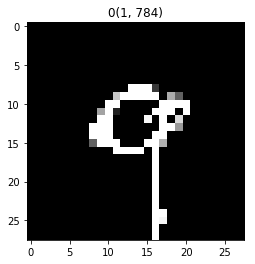

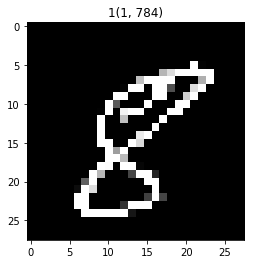

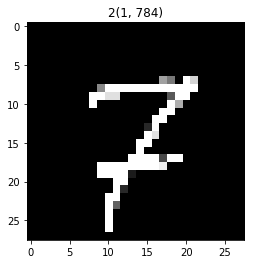

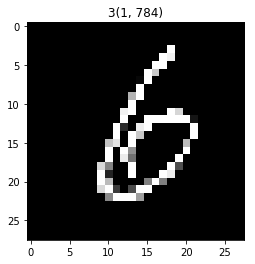

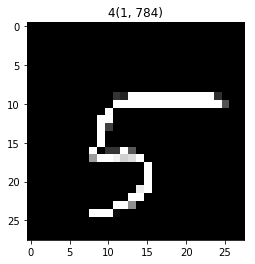

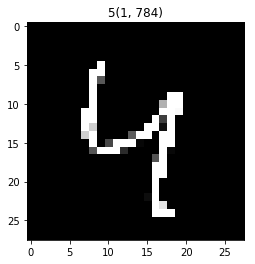

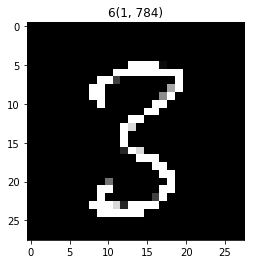

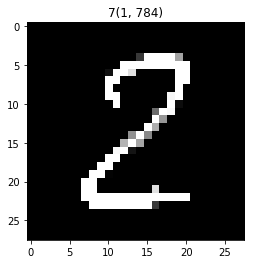

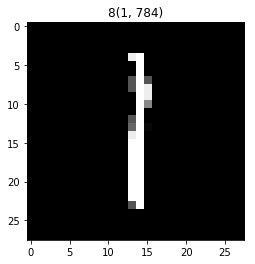

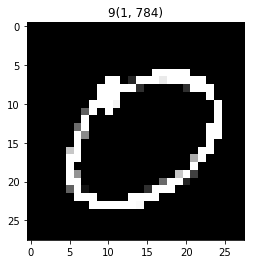

In [10]:
seg_list = segment_image(img_roi)
print(len(seg_list))

for i in range(len(seg_list)):
    seg_list[i] = preprocess(seg_list[i])
    
    plt.title(str(i) + str(seg_list[i].shape ))
    plt.imshow(seg_list[i].reshape((28, 28)), cmap='gray')
    plt.show() 

###### iii. Load Pre-trained Model and Make Predictions

In [11]:
#(1) Load Pretrained Model
interpreter = tf.contrib.lite.Interpreter(model_path=fn_tflite)
interpreter.allocate_tensors()

#(2) Get input and output tensors.
input_details = interpreter.get_input_details()
output_details = interpreter.get_output_details()

ip_idx, ip_shape = input_details[0]['index'], input_details[0]['shape']
op_idx, op_shape = output_details[0]['index'], output_details[0]['shape']
print("Tensorflow Model Expects:")
print("Input:\n\tIndex: {}\n\tShape: {}".format(ip_idx, ip_shape))
print("Output:\n\tIndex: {}\n\tShape: {}".format(op_idx, op_shape))

input_data = seg_list[0].astype(np.float32)
print("Provided Input Shape: ", input_data.shape)

#(3) Test model on user input data.
predictions = ["" for i in range(len(seg_list))]
for i in range(len(seg_list)):
    input_data = seg_list[i].astype(np.float32)
    interpreter.set_tensor(ip_idx, input_data)
    interpreter.invoke()
    output_data = interpreter.get_tensor(op_idx)
    
    predictions[i] = class_labels[np.argmax(output_data)]


For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
If you depend on functionality not listed there, please file an issue.

Tensorflow Model Expects:
Input:
	Index: 3
	Shape: [  1 784]
Output:
	Index: 12
	Shape: [ 1 10]
Provided Input Shape:  (1, 784)


###### iv. Display Predictions 

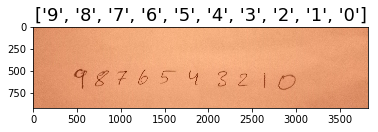

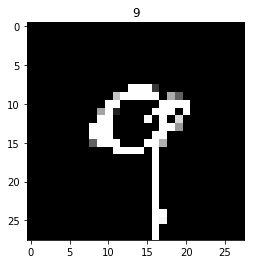

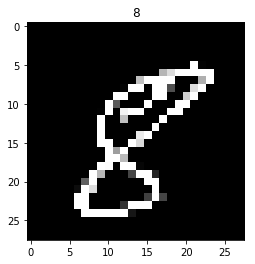

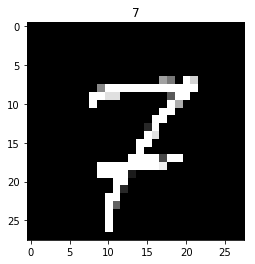

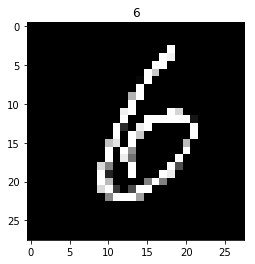

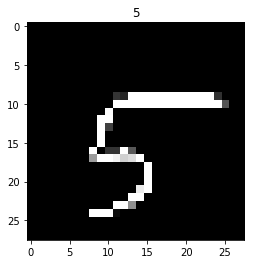

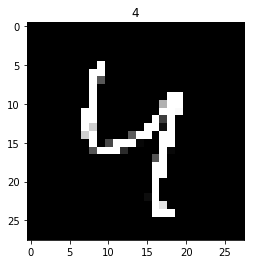

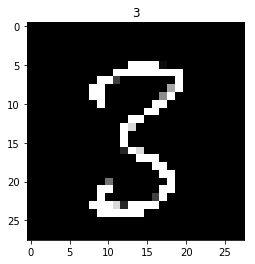

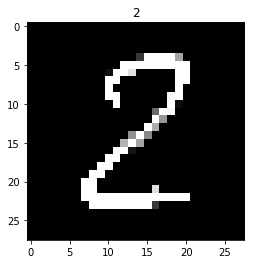

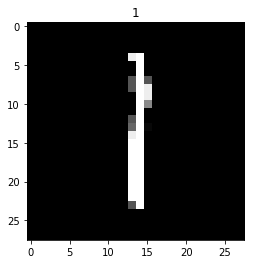

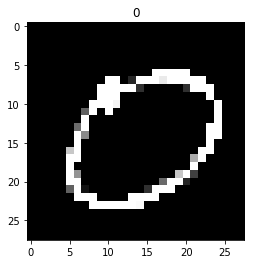

In [12]:
plt.title(predictions, fontsize=18)
plt.imshow(img, cmap='gray')
plt.show()

for i in range(len(seg_list)):
    plt.title(predictions[i])
    plt.imshow(seg_list[i].reshape((28, 28)), cmap='gray')
    plt.show()    

#### 5. Summary

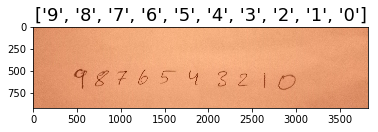

Tensor Configurations:
[{'dtype': <class 'numpy.float32'>,
  'index': 0,
  'name': 'dense_4/MatMul_bias',
  'quantization': (0.0, 0),
  'shape': array([200])},
 {'dtype': <class 'numpy.float32'>,
  'index': 1,
  'name': 'dense_4/Relu',
  'quantization': (0.0, 0),
  'shape': array([  1, 200])},
 {'dtype': <class 'numpy.float32'>,
  'index': 2,
  'name': 'dense_4/kernel/transpose',
  'quantization': (0.0, 0),
  'shape': array([200, 784])},
 {'dtype': <class 'numpy.float32'>,
  'index': 3,
  'name': 'dense_4_input',
  'quantization': (0.0, 0),
  'shape': array([  1, 784])},
 {'dtype': <class 'numpy.float32'>,
  'index': 4,
  'name': 'dense_5/MatMul_bias',
  'quantization': (0.0, 0),
  'shape': array([100])},
 {'dtype': <class 'numpy.float32'>,
  'index': 5,
  'name': 'dense_5/Relu',
  'quantization': (0.0, 0),
  'shape': array([  1, 100])},
 {'dtype': <class 'numpy.float32'>,
  'index': 6,
  'name': 'dense_5/kernel/transpose',
  'quantization': (0.0, 0),
  'shape': array([100, 200])},
 {'

In [13]:
plt.title(predictions, fontsize=18)
plt.imshow(img, cmap='gray')
plt.show()

if(train == True):
    print("Test Set:\n\tAccuracy: {}%\n\tLoss: {}\n\n".format(acc, loss))
    print('Model Configuration:')
    model.summary()
else:
    print('Tensor Configurations:')
    details = interpreter.get_tensor_details()
    pprint.pprint(details)